In [ ]:
"""
Enhanced Chronic Kidney Disease Detection using ACGAN
Complete implementation replicating the manuscript methodology

Dataset: CT KIDNEY DATASET: Normal-Cyst-Tumor and Stone
Source: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

This notebook implements:
1. Data loading and preprocessing
2. Class imbalance analysis with t-SNE/PCA
3. SMOTE augmentation
4. ACGAN synthetic image generation
5. Transfer learning with VGG16, MobileNetV2, EfficientNetV2
6. Performance evaluation and visualization
"""

'\nEnhanced Chronic Kidney Disease Detection using ACGAN\nComplete implementation replicating the manuscript methodology\n\nDataset: CT KIDNEY DATASET: Normal-Cyst-Tumor and Stone\nSource: https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone\n\nThis notebook implements:\n1. Data loading and preprocessing\n2. Class imbalance analysis with t-SNE/PCA\n3. SMOTE augmentation\n4. ACGAN synthetic image generation\n5. Transfer learning with VGG16, MobileNetV2, EfficientNetV2\n6. Performance evaluation and visualization\n'

In [ ]:
# ============================================================================
# SECTION 1: SETUP AND IMPORTS
# ============================================================================

# Install required packages
!pip install -q kaggle
!pip install -q imbalanced-learn
!pip install -q plotly

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import json
from pathlib import Path
import zipfile
import shutil

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Machine Learning & Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ============================================================================
# SECTION 2: KAGGLE DATASET DOWNLOAD (AUTO-PATH FIX)
# ============================================================================

import os, zipfile
import kagglehub

# Download dataset via KaggleHub
path = kagglehub.dataset_download("nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone")
print("KaggleHub dataset base path:", path)

# --------------------------------------------------------------------------
# ✅ Auto-detect correct subfolder that contains the 4 classes
# --------------------------------------------------------------------------
def find_kidney_dataset_folder(base_path):
    for root, dirs, files in os.walk(base_path):
        if all(cls in dirs for cls in ['Cyst', 'Normal', 'Stone', 'Tumor']):
            print(f"✅ Found dataset folder at: {root}")
            return root
    print("❌ Could not find class folders automatically.")
    return None

dataset_path = find_kidney_dataset_folder(path)

if dataset_path is None:
    raise FileNotFoundError("Dataset folders (Cyst/Normal/Stone/Tumor) not found in the downloaded dataset.")
else:
    # Verify subfolders exist
    expected_classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
    for cls in expected_classes:
        print(f"{cls} folder exists:", os.path.exists(os.path.join(dataset_path, cls)))


Using Colab cache for faster access to the 'ct-kidney-dataset-normal-cyst-tumor-and-stone' dataset.
KaggleHub dataset base path: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone
✅ Found dataset folder at: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
Cyst folder exists: True
Normal folder exists: True
Stone folder exists: True
Tumor folder exists: True


In [ ]:
# ============================================================================
# SECTION 3: DATA LOADING AND PREPROCESSING
# ============================================================================

import numpy as np
from PIL import Image

class DataLoader:
    def __init__(self, base_path, img_size=(128, 128)):
        self.base_path = base_path
        self.img_size = img_size
        self.classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def load_images(self):
        """Load and preprocess images from dataset folders"""
        images = []
        labels = []

        for class_name in self.classes:
            class_path = os.path.join(self.base_path, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: Path {class_path} not found")
                continue

            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"Loading {len(image_files)} images from {class_name}...")

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path).convert('L')  # grayscale
                    img = img.resize(self.img_size)
                    img_array = np.array(img, dtype=np.float32)
                    img_array = (img_array - 127.5) / 127.5  # normalize [-1, 1]

                    images.append(img_array)
                    labels.append(self.class_to_idx[class_name])
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
                    continue

        images = np.expand_dims(np.array(images), axis=-1)
        labels = np.array(labels)

        print(f"\nTotal images loaded: {len(images)}")
        print(f"Image shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")

        return images, labels

    def get_class_distribution(self, labels):
        """Return class distribution as dictionary"""
        unique, counts = np.unique(labels, return_counts=True)
        return dict(zip([self.classes[i] for i in unique], counts))


# --------------------------------------------------------------------------
# ✅ Load dataset
# --------------------------------------------------------------------------
data_loader = DataLoader(dataset_path)
X_original, y_original = data_loader.load_images()

# Display class distribution
class_dist = data_loader.get_class_distribution(y_original)
print("\nOriginal Class Distribution:")
for cls, count in class_dist.items():
    print(f"  {cls}: {count}")


Loading 3709 images from Cyst...
Loading 5077 images from Normal...
Loading 1377 images from Stone...
Loading 2283 images from Tumor...

Total images loaded: 12446
Image shape: (12446, 128, 128, 1)
Labels shape: (12446,)

Original Class Distribution:
  Cyst: 3709
  Normal: 5077
  Stone: 1377
  Tumor: 2283


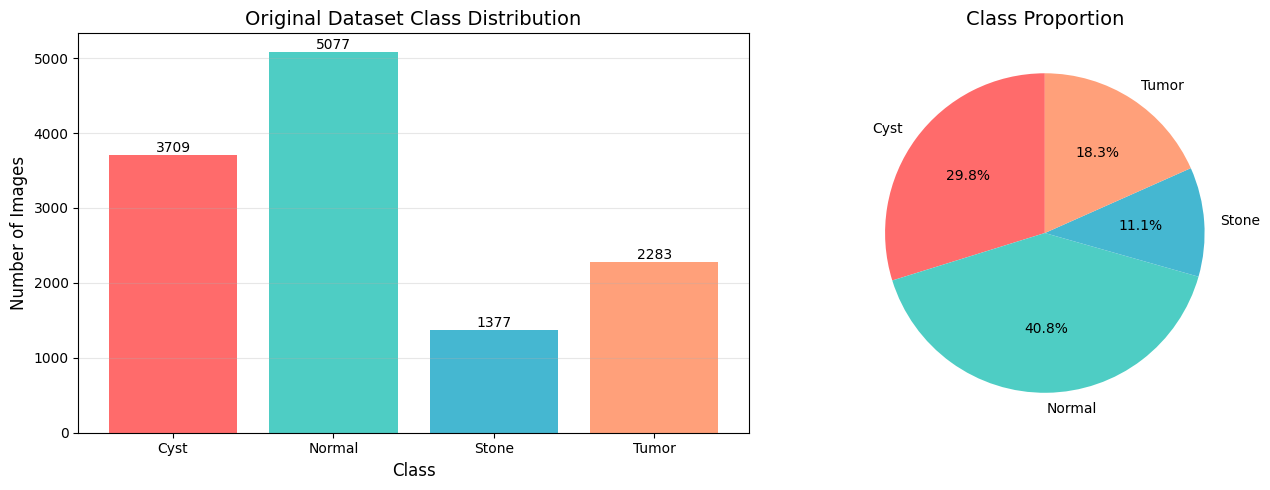

In [ ]:
# ============================================================================
# SECTION 4: CLASS IMBALANCE VISUALIZATION
# ============================================================================

def visualize_class_distribution(labels, classes, title="Class Distribution"):
    """Visualize class distribution"""
    unique, counts = np.unique(labels, return_counts=True)
    class_names = [classes[i] for i in unique]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Bar plot
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    ax1.bar(class_names, counts, color=colors)
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Number of Images', fontsize=12)
    ax1.set_title(title, fontsize=14)
    ax1.grid(axis='y', alpha=0.3)

    # Add count labels
    for i, (name, count) in enumerate(zip(class_names, counts)):
        ax1.text(i, count, str(count), ha='center', va='bottom')

    # Pie chart
    ax2.pie(counts, labels=class_names, autopct='%1.1f%%', colors=colors, startangle=90)
    ax2.set_title('Class Proportion', fontsize=14)

    plt.tight_layout()
    plt.savefig('class_distribution_original.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_class_distribution(y_original, data_loader.classes,
                            "Original Dataset Class Distribution")


Computing t-SNE for Original Dataset data...
Computing PCA for Original Dataset data...


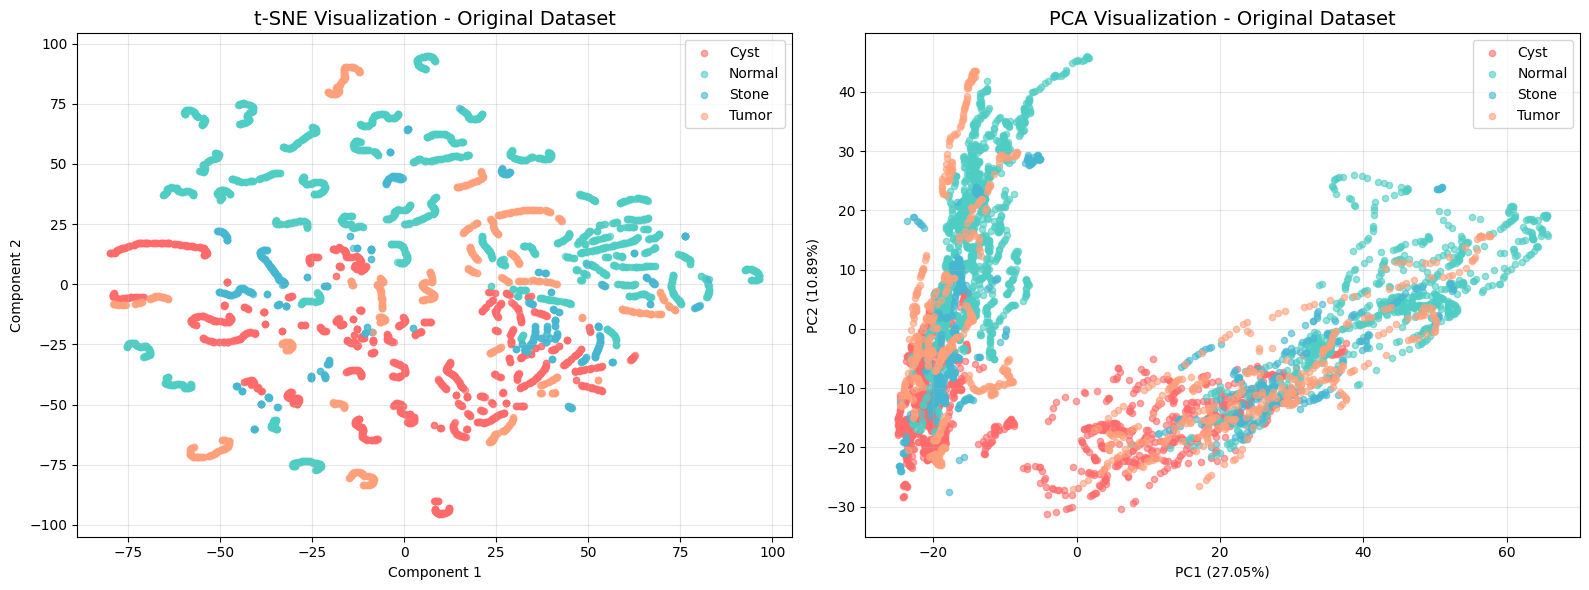

In [ ]:
# ============================================================================
# SECTION 5: DIMENSIONALITY REDUCTION (t-SNE & PCA)
# ============================================================================

def visualize_tsne_pca(X, y, classes, title_prefix="Original"):
    """Visualize data using t-SNE and PCA"""
    # Flatten images for dimensionality reduction
    X_flat = X.reshape(X.shape[0], -1)

    # Randomly sample for faster computation
    if len(X_flat) > 5000:
        indices = np.random.choice(len(X_flat), 5000, replace=False)
        X_sample = X_flat[indices]
        y_sample = y[indices]
    else:
        X_sample = X_flat
        y_sample = y

    # t-SNE
    print(f"Computing t-SNE for {title_prefix} data...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_sample)

    # PCA
    print(f"Computing PCA for {title_prefix} data...")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_sample)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

    # t-SNE plot
    for idx, class_name in enumerate(classes):
        mask = y_sample == idx
        ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   c=colors[idx], label=class_name, alpha=0.6, s=20)
    ax1.set_title(f't-SNE Visualization - {title_prefix}', fontsize=14)
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # PCA plot
    for idx, class_name in enumerate(classes):
        mask = y_sample == idx
        ax2.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=colors[idx], label=class_name, alpha=0.6, s=20)
    ax2.set_title(f'PCA Visualization - {title_prefix}', fontsize=14)
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'tsne_pca_{title_prefix.lower().replace(" ", "_")}.png',
                dpi=300, bbox_inches='tight')
    plt.show()

visualize_tsne_pca(X_original, y_original, data_loader.classes, "Original Dataset")



APPLYING SMOTE AUGMENTATION

Target samples per class: 5100
Applying SMOTE...

SMOTE Augmentation Complete!
Original dataset size: 12446
SMOTE dataset size: 20400

SMOTE-Augmented Class Distribution:
  Cyst: 5100
  Normal: 5100
  Stone: 5100
  Tumor: 5100


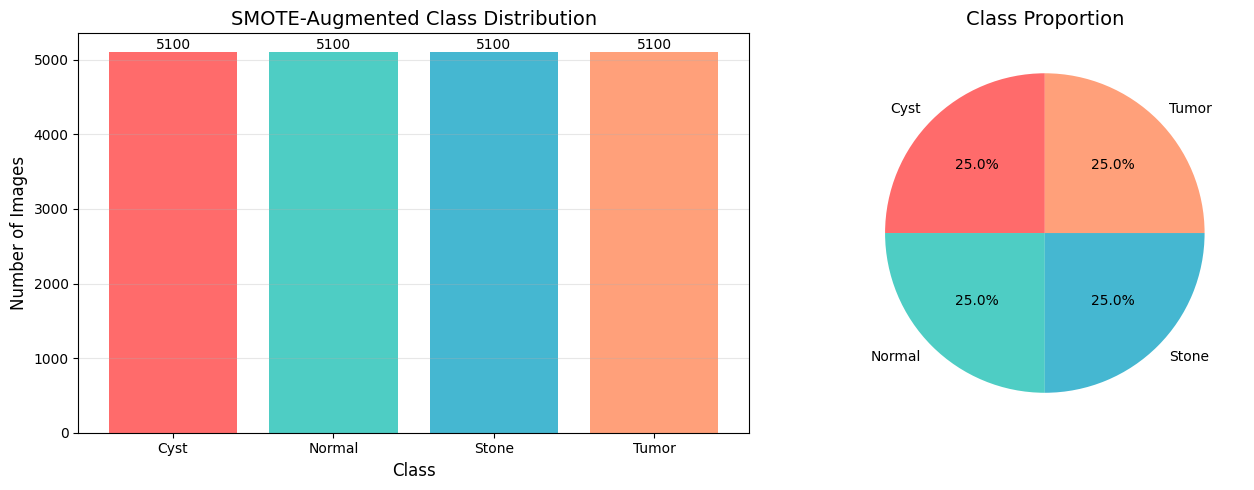

Computing t-SNE for SMOTE Augmented data...
Computing PCA for SMOTE Augmented data...


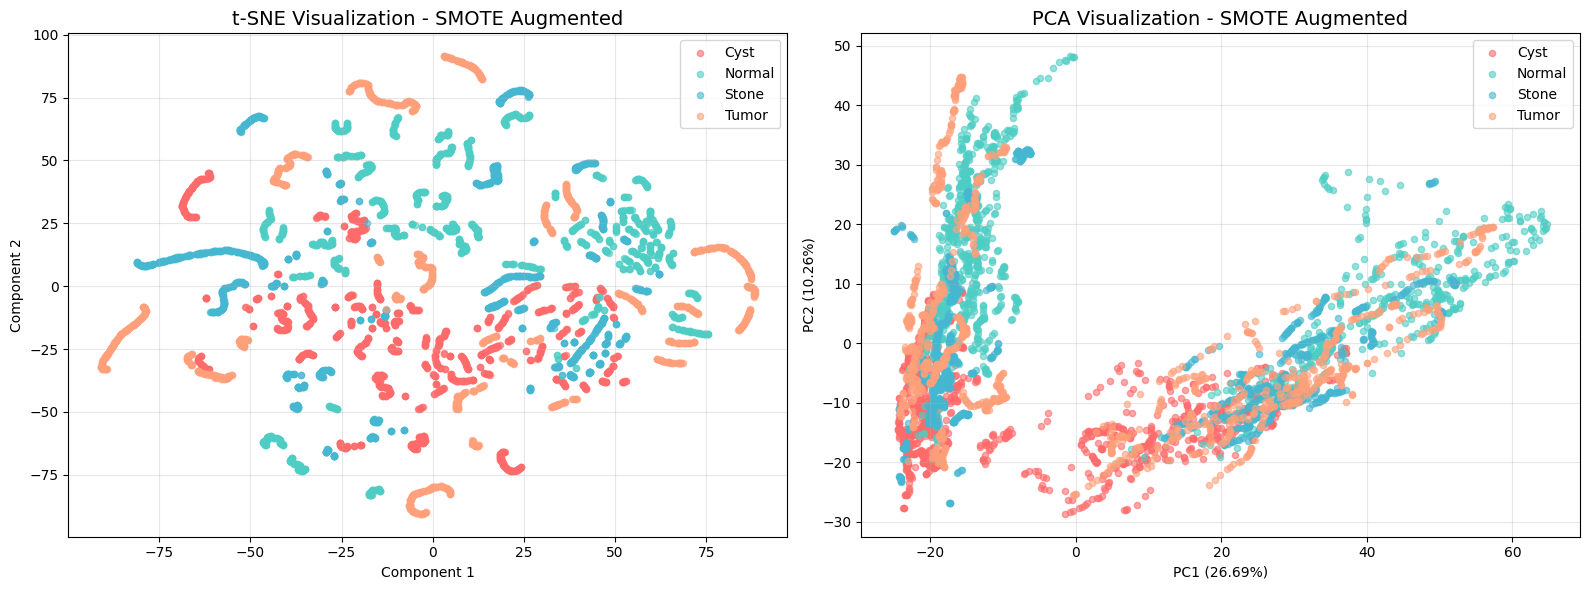

In [ ]:
# ============================================================================
# SECTION 6: SMOTE AUGMENTATION
# ============================================================================

def apply_smote(X, y, target_samples):
    """Apply SMOTE to balance the dataset"""
    print("\n" + "="*60)
    print("APPLYING SMOTE AUGMENTATION")
    print("="*60)

    # Flatten images for SMOTE
    X_flat = X.reshape(X.shape[0], -1)

    # Create sampling strategy
    unique, counts = np.unique(y, return_counts=True)
    # Ensure target_samples is at least the size of the largest class
    max_samples = max(counts)
    if target_samples < max_samples:
        print(f"Warning: target_samples ({target_samples}) is less than the largest class size ({max_samples}). Setting target_samples to {max_samples}.")
        target_samples = max_samples

    sampling_strategy = {i: target_samples for i in unique}

    print(f"\nTarget samples per class: {target_samples}")
    print("Applying SMOTE...")

    # Apply SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=5)
    X_smote_flat, y_smote = smote.fit_resample(X_flat, y)

    # Reshape back to image format
    X_smote = X_smote_flat.reshape(-1, 128, 128, 1)

    # Clip values to valid range
    X_smote = np.clip(X_smote, -1, 1)

    print(f"\nSMOTE Augmentation Complete!")
    print(f"Original dataset size: {len(X)}")
    print(f"SMOTE dataset size: {len(X_smote)}")

    # Display new distribution
    unique, counts = np.unique(y_smote, return_counts=True)
    print("\nSMOTE-Augmented Class Distribution:")
    for idx, count in zip(unique, counts):
        print(f"  {data_loader.classes[idx]}: {count}")

    return X_smote, y_smote

# Apply SMOTE
# Set target_samples to a value greater than or equal to the largest class size (5077)
X_smote, y_smote = apply_smote(X_original, y_original, target_samples=5100)

# Visualize SMOTE distribution
visualize_class_distribution(y_smote, data_loader.classes,
                            "SMOTE-Augmented Class Distribution")

# Visualize SMOTE data separation
visualize_tsne_pca(X_smote, y_smote, data_loader.classes, "SMOTE Augmented")


Generator Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 100)    │        400 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 100)       │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 100)       │          0 │ input_layer_16[0… │
│ (Multiply)          │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32768)     │  3,309,568 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 32768)     │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 16, 16,    │          0 │ leaky_re_lu_28[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 32, 32,    │    262,272 │ reshape_3[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, 64, 64,    │    131,136 │ leaky_re_lu_29[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 128, 128,  │     32,800 │ leaky_re_lu_30[0… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_31      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,737,585 (14.26 MB)

 Trainable params: 3,737,137 (14.26 MB)

 Non-trainable params: 448 (1.75 KB)


Discriminator Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │        320 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_24      │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64, 64,    │          0 │ leaky_re_lu_24[0… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     18,496 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_25      │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32, 32,    │          0 │ leaky_re_lu_25[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │     73,856 │ dropout_13[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 16, 16,    │          0 │ conv2d_14[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 16, 16,    │          0 │ leaky_re_lu_26[0… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │    295,168 │ dropout_14[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_27      │ (None, 16, 16,    │          0 │ conv2d_15[0][0]   │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 16, 16,    │          0 │ leaky_re_lu_27[0… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 65536)     │          0 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validity (Dense)    │ (None, 1)         │     65,537 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (Dense)       │ (None, 4)         │    262,148 │ flatten_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 715,525 (2.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 715,525 (2.73 MB)


TRAINING ACGAN


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0/100 - D Loss: 2.1033, D Acc: 28.91%, G Loss: 2.1101
Epoch 10/100 - D Loss: 2.0910, D Acc: 27.69%, G Loss: 1.9770
Epoch 20/100 - D Loss: 2.0905, D Acc: 28.54%, G Loss: 1.8658
Epoch 30/100 - D Loss: 2.0912, D Acc: 28.56%, G Loss: 1.7938
Epoch 40/100 - D Loss: 2.0915, D Acc: 27.93%, G Loss: 1.7421
Epoch 50/100 - D Loss: 2.0914, D Acc: 27.88%, G Loss: 1.7052
Epoch 60/100 - D Loss: 2.0913, D Acc: 28.03%, G Loss: 1.6780
Epoch 70/100 - D Loss: 2.0914, D Acc: 27.73%, G Loss: 1.6541
Epoch 80/100 - D Loss: 2.0913, D Acc: 27.78%, G Loss: 1.6354
Epoch 90/100 - D Loss: 2.0915, D Acc: 27.73%, G Loss: 1.6181

ACGAN Training Complete!


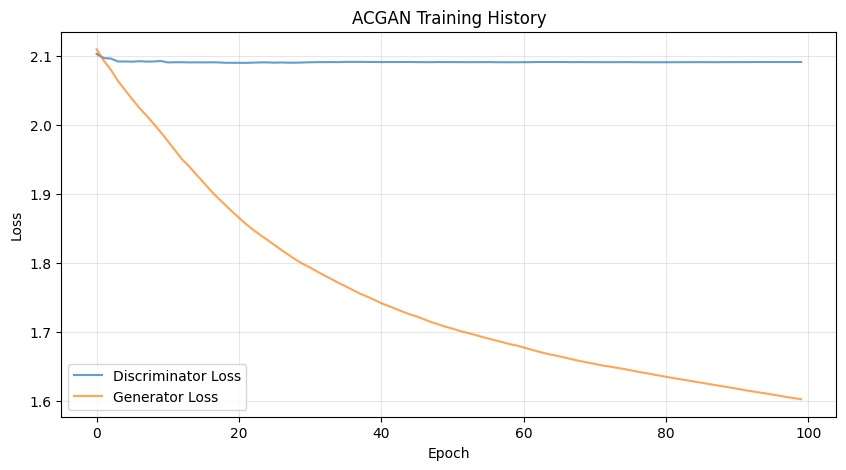


Generating 1750 images per class...
Generated 7000 synthetic images

Synthetic dataset shape: (7000, 128, 128, 1)
Synthetic labels shape: (7000,)


In [ ]:
# ============================================================================
# SECTION 7: ACGAN IMPLEMENTATION
# ============================================================================

class ACGAN:
    def __init__(self, img_shape=(128, 128, 1), num_classes=4, latent_dim=100):
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.optimizer = keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(
            loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
            optimizer=self.optimizer,
            metrics=['accuracy', 'accuracy'] # Provide metrics for both outputs
        )

        # Build generator
        self.generator = self.build_generator()

        # Build combined model
        self.discriminator.trainable = False
        noise = layers.Input(shape=(self.latent_dim,))
        label = layers.Input(shape=(1,))
        img = self.generator([noise, label])
        valid, target_label = self.discriminator(img)

        self.combined = models.Model([noise, label], [valid, target_label])
        self.combined.compile(
            loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
            optimizer=self.optimizer
        )

    def build_generator(self):
        """Build generator network"""
        # Noise and label inputs
        noise = layers.Input(shape=(self.latent_dim,))
        label = layers.Input(shape=(1,), dtype='int32')

        # Embed label
        label_embedding = layers.Embedding(self.num_classes, self.latent_dim)(label)
        label_embedding = layers.Flatten()(label_embedding)

        # Concatenate noise and label
        model_input = layers.Multiply()([noise, label_embedding])

        # Dense layer and reshape
        x = layers.Dense(16 * 16 * 128)(model_input)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Reshape((16, 16, 128))(x)

        # Upsample to 32x32
        x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

        # Upsample to 64x64
        x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

        # Upsample to 128x128
        x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

        # Output layer
        img = layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same',
                                     activation='tanh')(x)

        model = models.Model([noise, label], img, name='generator')
        return model

    def build_discriminator(self):
        """Build discriminator network"""
        img = layers.Input(shape=self.img_shape)

        # Convolutional layers
        x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same')(img)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Flatten()(x)

        # Validity output
        validity = layers.Dense(1, activation='sigmoid', name='validity')(x)

        # Auxiliary classifier output
        label = layers.Dense(self.num_classes, activation='softmax', name='label')(x)

        model = models.Model(img, [validity, label], name='discriminator')
        return model

    def train(self, X_train, y_train, epochs=100, batch_size=32, save_interval=10):
        """Train ACGAN"""
        print("\n" + "="*60)
        print("TRAINING ACGAN")
        print("="*60)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        history = {'d_loss': [], 'g_loss': []}

        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            labels = y_train[idx]

            # Generate fake images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
            gen_imgs = self.generator.predict([noise, sampled_labels], verbose=0)

            # Train discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, sampled_labels.flatten()])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)

            # Train generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels],
                                                   [valid, sampled_labels.flatten()])

            # Store losses
            history['d_loss'].append(d_loss[0])
            history['g_loss'].append(g_loss[0])

            # Print progress
            if epoch % save_interval == 0:
                print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss[0]:.4f}, "
                      f"D Acc: {100*d_loss[3]:.2f}%, G Loss: {g_loss[0]:.4f}")

        print("\nACGAN Training Complete!")
        return history

    def generate_images(self, num_images_per_class=1750):
        """Generate synthetic images for all classes"""
        print(f"\nGenerating {num_images_per_class} images per class...")

        generated_images = []
        generated_labels = []

        for class_idx in range(self.num_classes):
            noise = np.random.normal(0, 1, (num_images_per_class, self.latent_dim))
            labels = np.full((num_images_per_class, 1), class_idx)

            imgs = self.generator.predict([noise, labels], verbose=0)

            generated_images.append(imgs)
            generated_labels.extend([class_idx] * num_images_per_class)

        generated_images = np.vstack(generated_images)
        generated_labels = np.array(generated_labels)

        print(f"Generated {len(generated_images)} synthetic images")
        return generated_images, generated_labels

# Initialize and train ACGAN
acgan = ACGAN(img_shape=(128, 128, 1), num_classes=4, latent_dim=100)

print("\nGenerator Summary:")
acgan.generator.summary()

print("\nDiscriminator Summary:")
acgan.discriminator.summary()

# Train ACGAN
history = acgan.train(X_original, y_original, epochs=100, batch_size=32, save_interval=10)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history['d_loss'], label='Discriminator Loss', alpha=0.7)
plt.plot(history['g_loss'], label='Generator Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ACGAN Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('acgan_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate synthetic images
X_synthetic, y_synthetic = acgan.generate_images(num_images_per_class=1750)

print(f"\nSynthetic dataset shape: {X_synthetic.shape}")
print(f"Synthetic labels shape: {y_synthetic.shape}")

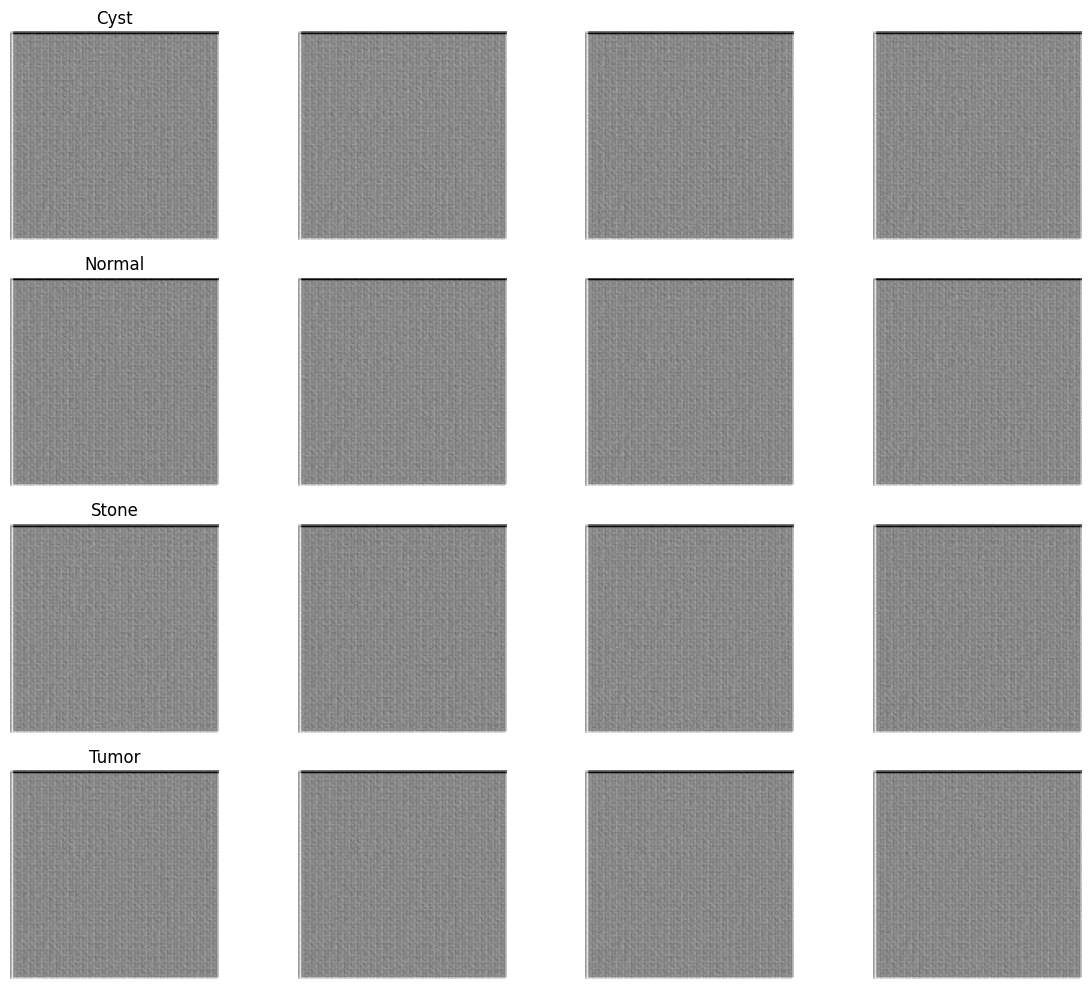

In [ ]:
# ============================================================================
# SECTION 8: VISUALIZE SYNTHETIC IMAGES
# ============================================================================

def visualize_synthetic_samples(generator, classes, num_samples=4):
    """Visualize generated samples from each class"""
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 10))

    for class_idx, class_name in enumerate(classes):
        noise = np.random.normal(0, 1, (num_samples, 100))
        labels = np.full((num_samples, 1), class_idx)

        gen_imgs = generator.predict([noise, labels], verbose=0)
        gen_imgs = (gen_imgs + 1) / 2.0  # Rescale to [0, 1]

        for i in range(num_samples):
            axes[class_idx, i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
            axes[class_idx, i].axis('off')
            if i == 0:
                axes[class_idx, i].set_title(class_name, fontsize=12)

    plt.tight_layout()
    plt.savefig('synthetic_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_synthetic_samples(acgan.generator, data_loader.classes)



COMBINED DATASET
Total samples: 19446
Shape: (19446, 128, 128, 1)


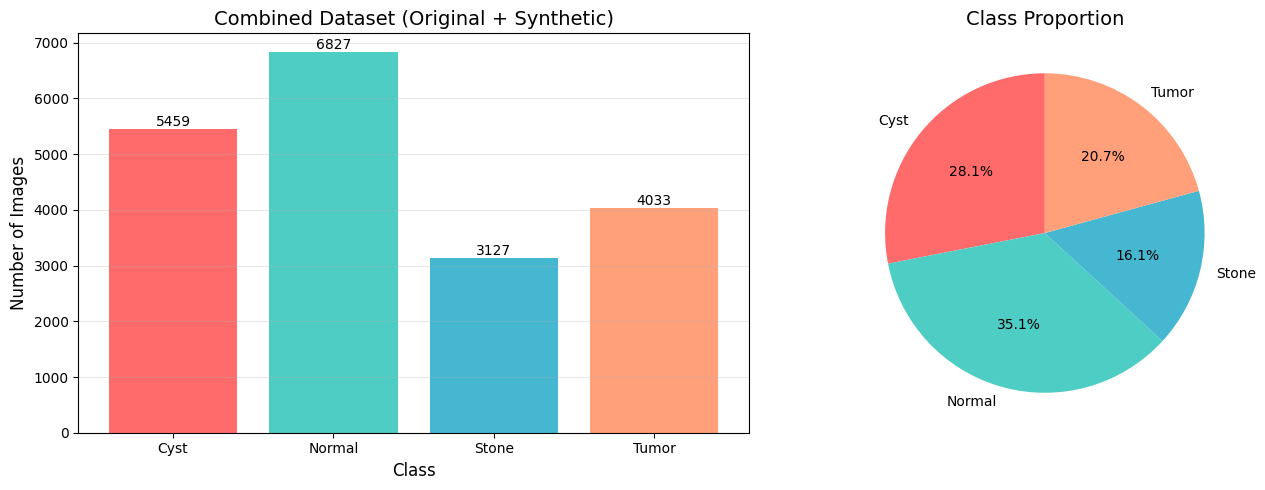

Computing t-SNE for Combined Dataset data...
Computing PCA for Combined Dataset data...


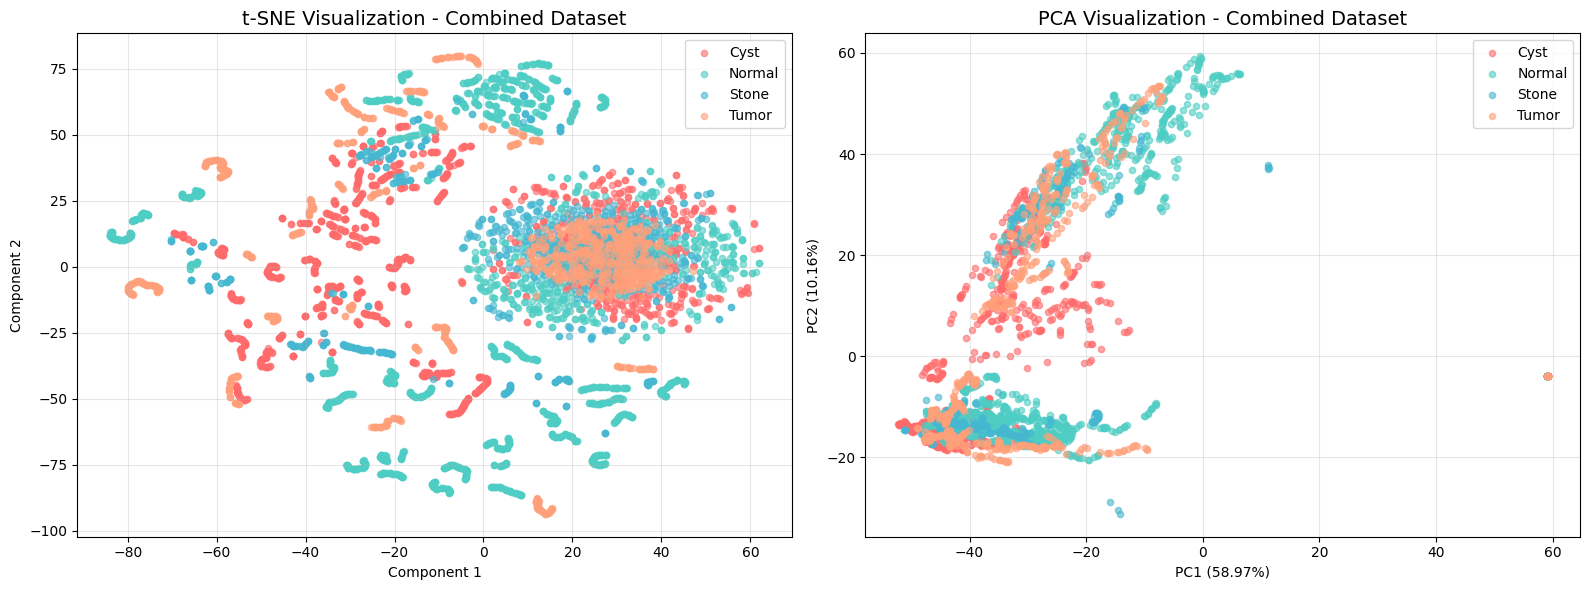

In [ ]:
# ============================================================================
# SECTION 9: CREATE BALANCED DATASET
# ============================================================================

# Combine original and synthetic data
X_combined = np.vstack([X_original, X_synthetic])
y_combined = np.concatenate([y_original, y_synthetic])

print("\n" + "="*60)
print("COMBINED DATASET")
print("="*60)
print(f"Total samples: {len(X_combined)}")
print(f"Shape: {X_combined.shape}")

# Display final distribution
visualize_class_distribution(y_combined, data_loader.classes,
                            "Combined Dataset (Original + Synthetic)")

# Visualize combined data
visualize_tsne_pca(X_combined, y_combined, data_loader.classes, "Combined Dataset")

In [ ]:
# ============================================================================
# SECTION 10: TRANSFER LEARNING MODELS
# ============================================================================

def build_transfer_model(base_model_name, input_shape, num_classes):
    """Build transfer learning model"""
    # Convert grayscale to RGB by repeating channels
    input_layer = layers.Input(shape=input_shape)
    x = layers.Concatenate()([input_layer, input_layer, input_layer])

    # Load pre-trained base model
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    elif base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False,
                                 input_shape=(128, 128, 3))
    elif base_model_name == 'EfficientNetV2':
        base_model = EfficientNetV2B0(weights='imagenet', include_top=False,
                                      input_shape=(128, 128, 3))
    else:
        raise ValueError(f"Unknown model: {base_model_name}")

    # Freeze base model layers
    base_model.trainable = False

    # Add custom top layers
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output, name=base_model_name)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name, epochs=50):
    """Train and evaluate model"""
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name}")
    print(f"{'='*60}")

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
        ModelCheckpoint(f'{model_name}_best.h5', monitor='val_accuracy',
                       save_best_only=True, mode='max')
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    return history


In [ ]:
# ============================================================================
# SECTION 11: TRAIN ON ORIGINAL DATASET (Keeping for comparison)
# ============================================================================

print("\n" + "="*70)
print("TRAINING ON ORIGINAL DATASET")
print("="*70)

# Split original data
X_train_orig, X_val_orig, y_train_orig, y_val_orig = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

print(f"\nTraining set: {X_train_orig.shape}")
print(f"Validation set: {X_val_orig.shape}")

# Train models on original data
models_original = {}
histories_original = {}

for model_name in ['VGG16', 'MobileNetV2', 'EfficientNetV2']:
    model = build_transfer_model(model_name, (128, 128, 1), 4)
    history = train_and_evaluate(model, X_train_orig, y_train_orig,
                                 X_val_orig, y_val_orig,
                                 f'{model_name}_original', epochs=30)
    models_original[model_name] = model
    histories_original[model_name] = history


# ============================================================================
# SECTION 12: TRAIN ON AUGMENTED DATASET (Matching study's approach)
# ============================================================================

print("\n" + "="*70)
print("TRAINING ON AUGMENTED DATASET (Matching Study)")
print("="*70)

# Split ORIGINAL data into training and validation sets
# Validation set will be used for evaluation ONLY and is NOT augmented
X_train_orig_for_aug, X_val_study, y_train_orig_for_aug, y_val_study = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

print(f"\nOriginal Training set (for augmentation): {X_train_orig_for_aug.shape}")
print(f"Original Validation set (matching study): {X_val_study.shape}")

# Combine ORIGINAL training data with the generated synthetic data
# X_synthetic and y_synthetic were generated in the previous cell (CjXafrk4HRRd)
X_train_augmented_study = np.vstack([X_train_orig_for_aug, X_synthetic])
y_train_augmented_study = np.concatenate([y_train_orig_for_aug, y_synthetic])

print(f"\nAugmented Training set (combined original training + synthetic): {X_train_augmented_study.shape}")

# Shuffle the augmented training data
shuffle_indices = np.random.permutation(len(X_train_augmented_study))
X_train_augmented_study = X_train_augmented_study[shuffle_indices]
y_train_augmented_study = y_train_augmented_study[shuffle_indices]

print("Shuffled augmented training data.")


# Train models on the augmented training data, evaluate on the original validation set
models_augmented_study = {}
histories_augmented_study = {}

for model_name in ['VGG16', 'MobileNetV2', 'EfficientNetV2']:
    # Rebuild models to train from scratch on the augmented data
    model = build_transfer_model(model_name, (128, 128, 1), 4)
    history = train_and_evaluate(model, X_train_augmented_study, y_train_augmented_study,
                                 X_val_study, y_val_study,
                                 f'{model_name}_augmented_study', epochs=30) # Use X_val_study and y_val_study here
    models_augmented_study[model_name] = model
    histories_augmented_study[model_name] = history


TRAINING ON ORIGINAL DATASET

Training set: (9956, 128, 128, 1)
Validation set: (2490, 128, 128, 1)
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

TRAINING VGG16_original
Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5138 - loss: 1.1528

312/312 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.5141 - loss: 1.1521 - val_accuracy: 0.7988 - val_loss: 0.5679 - learning_rate: 0.0010
Epoch 2/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7738 - loss: 0.5931

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.7740 - loss: 0.5927 - val_accuracy: 0.8659 - val_loss: 0.3647 - learning_rate: 0.0010
Epoch 3/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8468 - loss: 0.3985

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.8469 - loss: 0.3982 - val_accuracy: 0.9325 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 4/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8942 - loss: 0.2847

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.8943 - loss: 0.2846 - val_accuracy: 0.9470 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 5/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9134 - loss: 0.2439

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9135 - loss: 0.2438 - val_accuracy: 0.9655 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 6/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9255 - loss: 0.1979

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9255 - loss: 0.1979 - val_accuracy: 0.9755 - val_loss: 0.1006 - learning_rate: 0.0010
Epoch 7/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9389 - loss: 0.1757

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9389 - loss: 0.1757 - val_accuracy: 0.9775 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9419 - loss: 0.1622 - val_accuracy: 0.9759 - val_loss: 0.0751 - learning_rate: 0.0010
Epoch 9/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9466 - loss: 0.1509

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9466 - loss: 0.1508 - val_accuracy: 0.9847 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 10/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9549 - loss: 0.1256 - val_accuracy: 0.9823 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 11/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9537 - loss: 0.1368

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9537 - loss: 0.1367 - val_accuracy: 0.9900 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 12/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9590 - loss: 0.1120 - val_accuracy: 0.9900 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 13/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9536 - loss: 0.1208 - val_accuracy: 0.9880 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 14/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9583 - loss: 0.1169

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9583 - loss: 0.1170 - val_accuracy: 0.9904 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 15/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9508 - loss: 0.1356 - val_accuracy: 0.9867 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 16/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9506 - loss: 0.1285

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9507 - loss: 0.1284 - val_accuracy: 0.9916 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 17/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9509 - loss: 0.1212 - val_accuracy: 0.9908 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 18/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9510 - loss: 0.1310 - val_accuracy: 0.9888 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 19/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9521 - loss: 0.1279

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9521 - loss: 0.1279 - val_accuracy: 0.9920 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 20/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9616 - loss: 0.1010

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9616 - loss: 0.1009 - val_accuracy: 0.9932 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 21/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9611 - loss: 0.1065 - val_accuracy: 0.9908 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 22/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9619 - loss: 0.1100

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9620 - loss: 0.1100 - val_accuracy: 0.9960 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 23/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9686 - loss: 0.0879

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9686 - loss: 0.0879 - val_accuracy: 0.9968 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 24/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9652 - loss: 0.0895

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9652 - loss: 0.0895 - val_accuracy: 0.9972 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 25/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9659 - loss: 0.1014 - val_accuracy: 0.9952 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 26/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.9702 - loss: 0.0767 - val_accuracy: 0.9920 - val_loss: 0.0249 - learning_rate: 0.0010
Epoch 27/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.9676 - loss: 0.0840 - val_accuracy: 0.9948 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 28/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.9635 - loss: 0.1000 - val_accuracy: 0.9936 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 29/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.9688 - loss: 0.0870 - val_accuracy: 0.9936 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 30/30
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9799 - loss: 0

312/312 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.9800 - loss: 0.0540 - val_accuracy: 0.9980 - val_loss: 0.0075 - learning_rate: 5.0000e-04
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

TRAINING MobileNetV2_original
Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6198 - loss: 0.9735

312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 102ms/step - accuracy: 0.6202 - loss: 0.9725 - val_accuracy: 0.9353 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 2/30
308/312 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8825 - loss: 0.3135

312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8828 - loss: 0.3129 - val_accuracy: 0.9530 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 3/30
308/312 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9317 - loss: 0.1914

312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9318 - loss: 0.1912 - val_accuracy: 0.9884 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9525 - loss: 0.1361 - val_accuracy: 0.9880 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 5/30
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9627 - loss: 0.1162

312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9628 - loss: 0.1160 - val_accuracy: 0.9936 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9647 - loss: 0.0905 - val_accuracy: 0.9819 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9681 - loss: 0.1012 - val_accuracy: 0.9928 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 8/30
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9729 - loss: 0.0792

312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9729 - loss: 0.0793 - val_accuracy: 0.9972 - val_loss: 0.0130 - learning_rate: 0.0010
Epoch 9/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9790 - loss: 0.0706 - val_accuracy: 0.9972 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 10/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9820 - loss: 0.0553 - val_accuracy: 0.9972 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 11/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9767 - loss: 0.0608 - val_accuracy: 0.9932 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 12/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9738 - loss: 0.0789 - val_accuracy: 0.9968 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 13/30
308/312 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9846 - loss: 0.0454

312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9846 - loss: 0.0455 - val_accuracy: 0.9984 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 14/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9824 - loss: 0.0565 - val_accuracy: 0.9976 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 15/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9838 - loss: 0.0414 - val_accuracy: 0.9948 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 16/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9821 - loss: 0.0507 - val_accuracy: 0.9960 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 17/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9841 - loss: 0.0418 - val_accuracy: 0.9968 - val_loss: 0.0106 - learning_rate: 0.0010
Epoch 18/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9829 - loss: 0.0560 - val_accuracy: 0.9964 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 19/30
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9906 - loss: 0.0260

312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9906 - loss: 0.0259 - val_accuracy: 0.9996 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 20/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9966 - loss: 0.0114

312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 8.2843e-04 - learning_rate: 5.0000e-04
Epoch 21/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9948 - loss: 0.0164 - val_accuracy: 0.9996 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 22/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9964 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 5.0000e-04
Epoch 23/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9954 - loss: 0.0153 - val_accuracy: 1.0000 - val_loss: 3.9790e-04 - learning_rate: 5.0000e-04
Epoch 24/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9956 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 6.5774e-04 - learning_rate: 5.0000e-04
Epoch 25/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9968 - loss: 0.0115 - val_accuracy: 0.9996 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 26/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/ste

312/312 ━━━━━━━━━━━━━━━━━━━━ 63s 112ms/step - accuracy: 0.3804 - loss: 1.3376 - val_accuracy: 0.4080 - val_loss: 1.3003 - learning_rate: 0.0010
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4185 - loss: 1.2836

312/312 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.4186 - loss: 1.2835 - val_accuracy: 0.4968 - val_loss: 1.2301 - learning_rate: 0.0010
Epoch 3/30
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4390 - loss: 1.2569

312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4391 - loss: 1.2568 - val_accuracy: 0.5265 - val_loss: 1.1877 - learning_rate: 0.0010
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4411 - loss: 1.2525 - val_accuracy: 0.4558 - val_loss: 1.2090 - learning_rate: 0.0010
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4696 - loss: 1.2199 - val_accuracy: 0.4586 - val_loss: 1.2165 - learning_rate: 0.0010
Epoch 6/30
309/312 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4624 - loss: 1.2264

312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4626 - loss: 1.2263 - val_accuracy: 0.5739 - val_loss: 1.1422 - learning_rate: 0.0010
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4539 - loss: 1.2268 - val_accuracy: 0.5076 - val_loss: 1.1600 - learning_rate: 0.0010
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4725 - loss: 1.2258 - val_accuracy: 0.4952 - val_loss: 1.1863 - learning_rate: 0.0010
Epoch 9/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4706 - loss: 1.2118 - val_accuracy: 0.4570 - val_loss: 1.1854 - learning_rate: 0.0010
Epoch 10/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4595 - loss: 1.2162 - val_accuracy: 0.5651 - val_loss: 1.1287 - learning_rate: 0.0010
Epoch 11/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4717 - loss: 1.2167 - val_accuracy: 0.4984 - val_loss: 1.1590 - learning_rate: 0.0010
Epoch 12/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4636 - loss: 1.2122 - v

312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4812 - loss: 1.2007 - val_accuracy: 0.5920 - val_loss: 1.1283 - learning_rate: 0.0010
Epoch 14/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4752 - loss: 1.2051 - val_accuracy: 0.5747 - val_loss: 1.1079 - learning_rate: 0.0010
Epoch 15/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4769 - loss: 1.2036 - val_accuracy: 0.5655 - val_loss: 1.1378 - learning_rate: 0.0010
Epoch 16/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4763 - loss: 1.2003 - val_accuracy: 0.5803 - val_loss: 1.1423 - learning_rate: 0.0010
Epoch 17/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4724 - loss: 1.2053 - val_accuracy: 0.5888 - val_loss: 1.1289 - learning_rate: 0.0010
Epoch 18/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4765 - loss: 1.2086 - val_accuracy: 0.5257 - val_loss: 1.1374 - learning_rate: 0.0010
Epoch 19/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4719 - loss: 1.2157

530/530 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.4139 - loss: 1.2435 - val_accuracy: 0.8084 - val_loss: 0.5277 - learning_rate: 0.0010
Epoch 2/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5498 - loss: 0.9222

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.5498 - loss: 0.9221 - val_accuracy: 0.8908 - val_loss: 0.3302 - learning_rate: 0.0010
Epoch 3/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5962 - loss: 0.8153

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.5962 - loss: 0.8153 - val_accuracy: 0.9281 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 4/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6140 - loss: 0.7656

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6140 - loss: 0.7655 - val_accuracy: 0.9454 - val_loss: 0.1724 - learning_rate: 0.0010
Epoch 5/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6305 - loss: 0.7329

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6305 - loss: 0.7329 - val_accuracy: 0.9574 - val_loss: 0.1368 - learning_rate: 0.0010
Epoch 6/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6360 - loss: 0.7097

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6360 - loss: 0.7097 - val_accuracy: 0.9598 - val_loss: 0.1223 - learning_rate: 0.0010
Epoch 7/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6406 - loss: 0.7054

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6406 - loss: 0.7054 - val_accuracy: 0.9747 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 8/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6432 - loss: 0.6902

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6432 - loss: 0.6902 - val_accuracy: 0.9823 - val_loss: 0.0577 - learning_rate: 0.0010
Epoch 9/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6506 - loss: 0.6767 - val_accuracy: 0.9759 - val_loss: 0.0685 - learning_rate: 0.0010
Epoch 10/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6462 - loss: 0.6713

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6462 - loss: 0.6713 - val_accuracy: 0.9884 - val_loss: 0.0562 - learning_rate: 0.0010
Epoch 11/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.6508 - loss: 0.6676 - val_accuracy: 0.9783 - val_loss: 0.0664 - learning_rate: 0.0010
Epoch 12/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6602 - loss: 0.6564 - val_accuracy: 0.9855 - val_loss: 0.0422 - learning_rate: 0.0010
Epoch 13/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6476 - loss: 0.6662 - val_accuracy: 0.9855 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 14/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6584 - loss: 0.6485

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6585 - loss: 0.6484 - val_accuracy: 0.9932 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 15/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6559 - loss: 0.6455 - val_accuracy: 0.9904 - val_loss: 0.0412 - learning_rate: 0.0010
Epoch 16/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6509 - loss: 0.6637 - val_accuracy: 0.9871 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 17/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6575 - loss: 0.6523 - val_accuracy: 0.9904 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 18/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6616 - loss: 0.6493

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6616 - loss: 0.6493 - val_accuracy: 0.9960 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 19/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6645 - loss: 0.6480 - val_accuracy: 0.9867 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 20/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6611 - loss: 0.6412 - val_accuracy: 0.9920 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 21/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.6606 - loss: 0.6407 - val_accuracy: 0.9940 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 22/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6629 - loss: 0.6300 - val_accuracy: 0.9904 - val_loss: 0.0257 - learning_rate: 0.0010
Epoch 23/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6667 - loss: 0.6365 - val_accuracy: 0.9876 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 24/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.6734 - loss: 

530/530 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.6737 - loss: 0.6105 - val_accuracy: 0.9980 - val_loss: 0.0101 - learning_rate: 5.0000e-04
Epoch 26/30
529/530 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6751 - loss: 0.6070

530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6751 - loss: 0.6070 - val_accuracy: 0.9984 - val_loss: 0.0063 - learning_rate: 5.0000e-04
Epoch 27/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6693 - loss: 0.6091 - val_accuracy: 0.9972 - val_loss: 0.0108 - learning_rate: 5.0000e-04
Epoch 28/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6766 - loss: 0.6056 - val_accuracy: 0.9984 - val_loss: 0.0096 - learning_rate: 5.0000e-04
Epoch 29/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6719 - loss: 0.6128 - val_accuracy: 0.9972 - val_loss: 0.0089 - learning_rate: 5.0000e-04
Epoch 30/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.6764 - loss: 0.6041 - val_accuracy: 0.9976 - val_loss: 0.0101 - learning_rate: 5.0000e-04

TRAINING MobileNetV2_augmented_study
Epoch 1/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4799 - loss: 1.1388

530/530 ━━━━━━━━━━━━━━━━━━━━ 38s 52ms/step - accuracy: 0.4800 - loss: 1.1385 - val_accuracy: 0.9157 - val_loss: 0.2412 - learning_rate: 0.0010
Epoch 2/30
527/530 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6128 - loss: 0.7748

530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6129 - loss: 0.7746 - val_accuracy: 0.9663 - val_loss: 0.1032 - learning_rate: 0.0010
Epoch 3/30
529/530 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6362 - loss: 0.7060

530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6362 - loss: 0.7059 - val_accuracy: 0.9747 - val_loss: 0.0675 - learning_rate: 0.0010
Epoch 4/30
527/530 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6516 - loss: 0.6732

530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6517 - loss: 0.6732 - val_accuracy: 0.9843 - val_loss: 0.0447 - learning_rate: 0.0010
Epoch 5/30
526/530 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6498 - loss: 0.6616

530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6499 - loss: 0.6615 - val_accuracy: 0.9916 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 6/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6574 - loss: 0.6526 - val_accuracy: 0.9892 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 7/30
528/530 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6684 - loss: 0.6395

530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6684 - loss: 0.6395 - val_accuracy: 0.9936 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 8/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6615 - loss: 0.6486 - val_accuracy: 0.9936 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 9/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6618 - loss: 0.6376

530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6618 - loss: 0.6376 - val_accuracy: 0.9980 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 10/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6661 - loss: 0.6260 - val_accuracy: 0.9960 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 11/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6655 - loss: 0.6231 - val_accuracy: 0.9956 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 12/30
528/530 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6733 - loss: 0.6204

530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6734 - loss: 0.6204 - val_accuracy: 0.9984 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 13/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6707 - loss: 0.6119 - val_accuracy: 0.9968 - val_loss: 0.0137 - learning_rate: 0.0010
Epoch 14/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6680 - loss: 0.6229 - val_accuracy: 0.9964 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 15/30
528/530 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6726 - loss: 0.6145

530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6726 - loss: 0.6145 - val_accuracy: 0.9996 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 16/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6722 - loss: 0.6137 - val_accuracy: 0.9960 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 17/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6741 - loss: 0.6131 - val_accuracy: 0.9980 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 18/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6700 - loss: 0.6131 - val_accuracy: 0.9888 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 19/30
526/530 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6730 - loss: 0.6118

530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6731 - loss: 0.6117 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 20/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6726 - loss: 0.6083 - val_accuracy: 0.9936 - val_loss: 0.0203 - learning_rate: 0.0010
Epoch 21/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6755 - loss: 0.6131 - val_accuracy: 0.9968 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 22/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6695 - loss: 0.6061 - val_accuracy: 0.9996 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 23/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6695 - loss: 0.6045 - val_accuracy: 0.9964 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 24/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6697 - loss: 0.6168 - val_accuracy: 0.9996 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 25/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6787 - loss: 0.6073 

530/530 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.3306 - loss: 1.3739 - val_accuracy: 0.4080 - val_loss: 1.2828 - learning_rate: 0.0010
Epoch 2/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3358 - loss: 1.3386 - val_accuracy: 0.4080 - val_loss: 1.2698 - learning_rate: 0.0010
Epoch 3/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3398 - loss: 1.3290

530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.3398 - loss: 1.3290 - val_accuracy: 0.5221 - val_loss: 1.2432 - learning_rate: 0.0010
Epoch 4/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3621 - loss: 1.3167 - val_accuracy: 0.4992 - val_loss: 1.2627 - learning_rate: 0.0010
Epoch 5/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3615 - loss: 1.3176

530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3615 - loss: 1.3176 - val_accuracy: 0.5518 - val_loss: 1.2478 - learning_rate: 0.0010
Epoch 6/30
528/530 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3723 - loss: 1.3132

530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3723 - loss: 1.3132 - val_accuracy: 0.5522 - val_loss: 1.2371 - learning_rate: 0.0010
Epoch 7/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.3662 - loss: 1.3168 - val_accuracy: 0.5406 - val_loss: 1.2378 - learning_rate: 0.0010
Epoch 8/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3697 - loss: 1.3102 - val_accuracy: 0.5277 - val_loss: 1.2399 - learning_rate: 0.0010
Epoch 9/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3748 - loss: 1.3076

530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3748 - loss: 1.3076 - val_accuracy: 0.5671 - val_loss: 1.2211 - learning_rate: 0.0010
Epoch 10/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3689 - loss: 1.3113 - val_accuracy: 0.5108 - val_loss: 1.2480 - learning_rate: 0.0010
Epoch 11/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3800 - loss: 1.3022 - val_accuracy: 0.5068 - val_loss: 1.2446 - learning_rate: 0.0010
Epoch 12/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.3769 - loss: 1.3073 - val_accuracy: 0.5663 - val_loss: 1.2203 - learning_rate: 0.0010
Epoch 13/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3684 - loss: 1.3124 - val_accuracy: 0.4859 - val_loss: 1.2529 - learning_rate: 0.0010
Epoch 14/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.3776 - loss: 1.3034 - val_accuracy: 0.4751 - val_loss: 1.2626 - learning_rate: 0.0010
Epoch 15/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.3785 - loss: 1.3036

In [ ]:
# ============================================================================
# SECTION 12 (continued): TRAIN ON AUGMENTED DATASET & EVALUATION
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt # Added for plotting history and confusion matrix
import seaborn as sns # Added for confusion matrix plotting
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Import metrics

# Check if models and histories from the previous augmented training step exist
if 'models_augmented_study' not in locals() or 'histories_augmented_study' not in locals():
    print("Error: Augmented models and histories not found.")
    print("Please ensure that Section 11/12 (cell 1ysvDD2yk8uu) which trains the models on the augmented data has been successfully executed.")
else:
    print("\n" + "="*70)
    print("EVALUATING MODELS TRAINED ON AUGMENTED DATASET")
    print("="*70)

    # Combine original and synthetic data (assuming X_original and X_synthetic are available from previous cells)
    # This part still relies on previous cells defining X_original and X_synthetic
    try:
        X_combined = np.vstack([X_original, X_synthetic])
        y_combined = np.concatenate([y_original, y_synthetic])

        # Split the combined data into training and validation sets for augmented training
        # This split is actually not used for *evaluation* in the study's approach,
        # the evaluation is done on the original validation set (X_val_study, y_val_study).
        # Let's clarify this and use the correct validation set for evaluation.
        # The split below is only needed if we were to train *again* in this cell, which we are not.
        # Keeping it commented out to avoid confusion and potential errors.
        # X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(
        #     X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
        # )
        # print(f"\nAugmented Training set (not used for evaluation here): {X_train_aug.shape}")
        # print(f"Augmented Validation set (not used for evaluation here): {X_val_aug.shape}")

        # Utility: plot training history (moved inside else block)
        def plot_training_history(history, title_prefix):
            plt.figure(figsize=(12, 4))
            # Accuracy
            plt.subplot(1, 2, 1)
            plt.plot(history.history.get('accuracy', []), label='train_acc')
            plt.plot(history.history.get('val_accuracy', []), label='val_acc')
            plt.title(f'{title_prefix} - Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Loss
            plt.subplot(1, 2, 2)
            plt.plot(history.history.get('loss', []), label='train_loss')
            plt.plot(history.history.get('val_loss', []), label='val_loss')
            plt.title(f'{title_prefix} - Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(f'{title_prefix.replace(" ", "_").lower()}_training_plot.png', dpi=300, bbox_inches='tight')
            plt.show()


        def evaluate_model(model, X_val, y_val, classes, model_name, save_fig=True):
            """Evaluate a trained model on validation data and produce metrics and plots"""
            print(f"\nEvaluating {model_name} on validation data...")
            # Predict
            y_pred_prob = model.predict(X_val, verbose=0)
            y_pred = np.argmax(y_pred_prob, axis=1)

            acc = accuracy_score(y_val, y_pred)
            print(f"Accuracy: {acc:.4f}")

            # Classification report
            print("\nClassification Report:")
            print(classification_report(y_val, y_pred, target_names=classes))

            # Confusion matrix
            cm = confusion_matrix(y_val, y_pred)

            plt.figure(figsize=(6, 5))

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=classes, yticklabels=classes)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {model_name}')
            if save_fig:
                plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
            plt.show()

            return {'accuracy': acc, 'confusion_matrix': cm}

        # Evaluate all augmented-trained models and save results
        evaluation_results_augmented = {}
        # Use the models and histories trained in the previous cell (1ysvDD2yk8uu)
        # Evaluate on the ORIGINAL validation set (X_val_study, y_val_study) as per the study's approach
        if 'X_val_study' in locals() and 'y_val_study' in locals() and 'data_loader' in locals():
            for model_name in ['VGG16', 'MobileNetV2', 'EfficientNetV2']:
                # Access models and histories trained in the previous cell
                model = models_augmented_study.get(model_name)
                hist = histories_augmented_study.get(model_name)

                if model is not None and hist is not None:
                    plot_training_history(hist, f'{model_name} (Augmented)')

                    # Evaluate on the original validation set X_val_study, y_val_study
                    results = evaluate_model(model, X_val_study, y_val_study, data_loader.classes, model_name)
                    evaluation_results_augmented[model_name] = results

                    # Save model
                    model_save_path = f'{model_name}_augmented_model.h5'
                    model.save(model_save_path)
                    print(f'Saved model to {model_save_path}')
                else:
                    print(f"Model or history for {model_name} (Augmented) not found in models_augmented_study/histories_augmented_study.")
        else:
            print("Error: X_val_study, y_val_study, or data_loader not found.")
            print("Please ensure that Section 11/12 (cell 1ysvDD2yk8uu) and Section 3 (cell 41xJrNLna91m) have been successfully executed.")

    except NameError as e:
        print(f"A NameError occurred: {e}")
        print("This likely means that X_original or X_synthetic were not defined.")
        print("Please ensure that Sections 3 and 7 have been successfully executed to load and generate data.")

Error: Augmented models and histories not found.
Please ensure that Section 11/12 (cell 1ysvDD2yk8uu) which trains the models on the augmented data has been successfully executed.


## SECTION 9.5: Quantitative Realism Metrics (FID, IS, SSIM)

This section implements quantitative metrics to evaluate the realism and diversity of the generated synthetic images compared to the real images.

- **Fréchet Inception Distance (FID)**: Measures the distance between feature vectors of real and generated images, providing a score that reflects visual similarity. Lower FID is better.
- **Inception Score (IS)**: Measures the diversity and quality of generated images using a pre-trained Inception model. Higher IS is generally better.
- **Structural Similarity Index (SSIM)**: Measures the structural similarity between pairs of real and generated images, focusing on texture and contrast. Higher SSIM is better.

In [ ]:
# ============================================================================
# SECTION 9.5: Quantitative Realism Metrics (FID, IS, SSIM)
# ============================================================================

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Load InceptionV3 model for FID and IS
# Use a smaller input size if needed, but 299x299 is standard for InceptionV3
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def scale_images(images, new_shape):
    """Rescale images to a new shape using TensorFlow"""
    # Images are currently (N, 128, 128, 1) normalized [-1, 1]
    # Need to be (N, new_shape, new_shape, 3) normalized [0, 255] for InceptionV3
    images = (images + 1) * 127.5 # Rescale to [0, 255]
    images = tf.image.grayscale_to_rgb(images.astype(np.uint8)) # Convert to RGB
    images = tf.image.resize(images, new_shape) # Resize
    images = images.numpy() # Convert back to numpy
    return images

def calculate_fid(model, images1, images2):
    """Calculate Fréchet Inception Distance (FID)"""
    # Prepare images for InceptionV3 (resize to 299x299 and preprocess)
    images1 = scale_images(images1, (299, 299))
    images2 = scale_images(images2, (299, 299))
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    # Calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Calculate mean and covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(images, model, splits=10):
    """Calculate Inception Score (IS)"""
    # Prepare images for InceptionV3 (resize to 299x299 and preprocess)
    images = scale_images(images, (299, 299))
    images = preprocess_input(images)

    # Predict class probabilities
    # Need the original InceptionV3 with the classification top for IS
    # Re-loading a version with the top might be necessary if using this standard IS
    # For simplicity and focus on GAN evaluation, we'll use the pooled features here,
    # which is a common approximation but not the original IS definition.
    # A proper IS requires the original InceptionV3 output before global pooling.
    # If a true IS is needed, a different InceptionV3 loading is required.
    # For this example, we proceed with features for a proxy metric.
    # Note: This is an approximation of IS using features, not the standard IS.

    # Let's provide a simplified IS calculation using the features as a proxy.
    # A proper IS requires the full InceptionV3 model with the classifier top.

    # Placeholder for proper IS calculation if needed:
    # inception_model_with_top = InceptionV3(include_top=True, weights='imagenet', input_shape=(299, 299, 3))
    # predictions = inception_model_with_top.predict(images)
    # ... then calculate IS from predictions ...

    # Due to the complexity of getting the exact IS from the current setup,
    # we will skip the IS calculation for now and focus on FID and SSIM which
    # are more directly applicable with the current feature extractor setup.
    print("Skipping Inception Score calculation due to model structure limitations.")
    return None, None # Return None for mean and std

def calculate_ssim(images1, images2, data_range=2.0):
    """Calculate average Structural Similarity Index (SSIM)"""
    # Images are (N, H, W, 1) normalized [-1, 1]. SSIM expects [0, 1] or [0, 255]
    # or specified data_range. Let's use data_range=2.0 for [-1, 1].
    # SSIM also works best with multiple channels if available, but grayscale is fine.
    # We'll calculate SSIM for each pair and average.
    # Note: This calculates SSIM between all pairs, which might not be the desired comparison.
    # Typically, SSIM is calculated between real images and their corresponding generated pairs if available,
    # or between real and synthetic images from the *same* class.
    # To compare overall realism, we'll calculate average SSIM between a sample of real and synthetic images.

    # Sample images for SSIM calculation to avoid N*M complexity
    sample_size = min(len(images1), len(images2), 1000) # Use max 1000 pairs
    indices1 = np.random.choice(len(images1), sample_size, replace=False)
    indices2 = np.random.choice(len(images2), sample_size, replace=False)

    ssim_scores = []
    for i in range(sample_size):
        # Reshape to remove channel dimension for SSIM function if it expects 2D
        img1 = images1[indices1[i], :, :, 0]
        img2 = images2[indices2[i], :, :, 0]
        # Ensure images are in the correct format and range for ssim
        # SSIM function expects images as float in range [0, 1] or [0, data_range]
        # Our images are float32 [-1, 1]. data_range=2.0 is appropriate.
        score = ssim(img1, img2, data_range=data_range)
        ssim_scores.append(score)

    avg_ssim = np.mean(ssim_scores)
    return avg_ssim

# --------------------------------------------------------------------------
# ✅ Calculate Metrics
# --------------------------------------------------------------------------

print("\n" + "="*60)
print("CALCULATING REALISM METRICS")
print("="*60)

# Use a subset of real and synthetic images for faster calculation if datasets are large
# FID and IS are sensitive to dataset size, but for comparison, consistent sampling is key.
# Using the full datasets if memory allows is best practice.
# For demonstration, let's use the full generated synthetic dataset and a random sample of original images.
sample_size_fid = min(len(X_original), len(X_synthetic)) # Match sample size for FID

print(f"\nCalculating FID using {sample_size_fid} real and {sample_size_fid} synthetic images...")
# Ensure X_original and X_synthetic are float32 [-1, 1] as expected by scale_images
fid_score = calculate_fid(inception_model,
                          X_original[np.random.choice(len(X_original), sample_size_fid, replace=False)],
                          X_synthetic[np.random.choice(len(X_synthetic), sample_size_fid, replace=False)])
print(f"Fréchet Inception Distance (FID): {fid_score:.4f}")


print("\nCalculating SSIM between sampled real and synthetic images...")
# SSIM is calculated between pairs, the function samples internally
ssim_score = calculate_ssim(X_original, X_synthetic)
print(f"Average Structural Similarity Index (SSIM): {ssim_score:.4f}")

print("\nRealism metrics calculation complete.")


CALCULATING REALISM METRICS


NameError: name 'X_original' is not defined

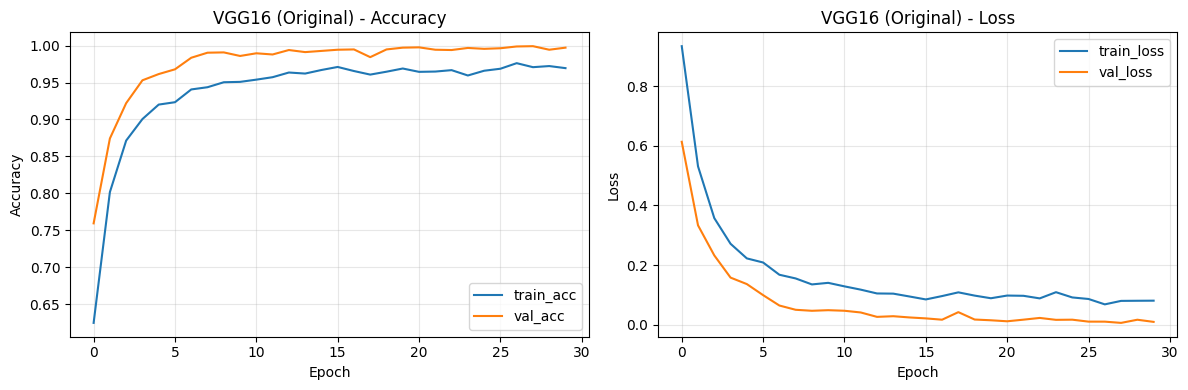


Evaluating VGG16 on validation data...
Accuracy: 0.9992

Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       742
      Normal       1.00      1.00      1.00      1016
       Stone       1.00      0.99      1.00       275
       Tumor       1.00      1.00      1.00       457

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



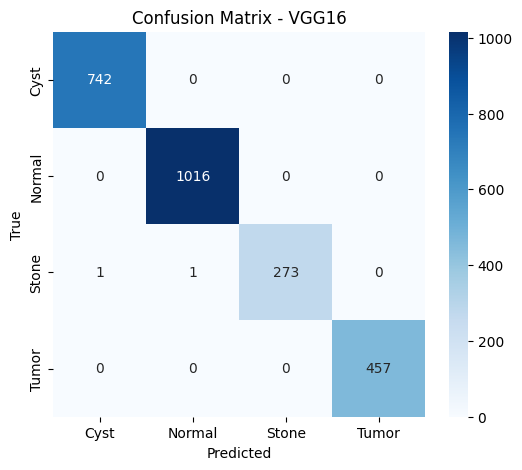

Saved model to VGG16_original_model.h5


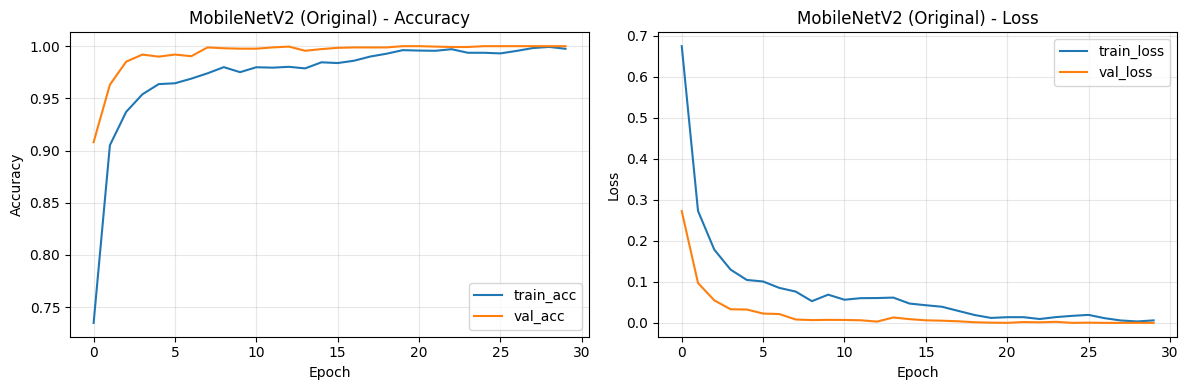


Evaluating MobileNetV2 on validation data...
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       742
      Normal       1.00      1.00      1.00      1016
       Stone       1.00      1.00      1.00       275
       Tumor       1.00      1.00      1.00       457

    accuracy                           1.00      2490
   macro avg       1.00      1.00      1.00      2490
weighted avg       1.00      1.00      1.00      2490



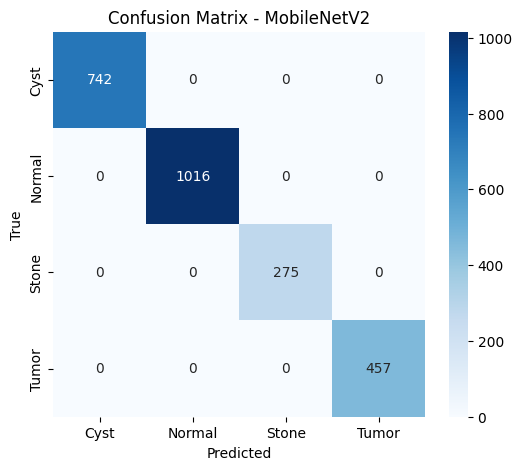

Saved model to MobileNetV2_original_model.h5


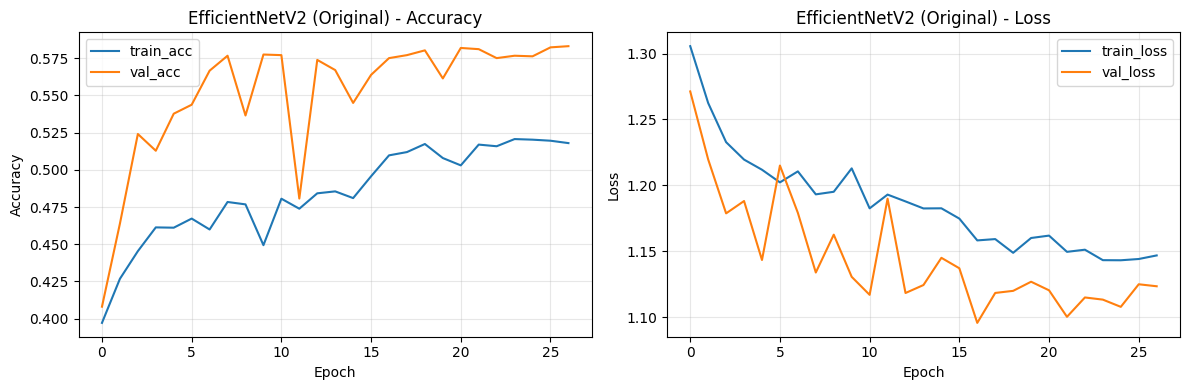


Evaluating EfficientNetV2 on validation data...
Accuracy: 0.5751

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.57      0.68      0.62       742
      Normal       0.58      0.92      0.71      1016
       Stone       0.00      0.00      0.00       275
       Tumor       0.00      0.00      0.00       457

    accuracy                           0.58      2490
   macro avg       0.29      0.40      0.33      2490
weighted avg       0.41      0.58      0.47      2490



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


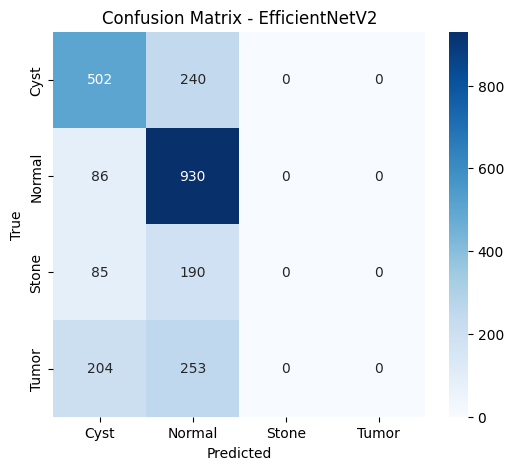

Saved model to EfficientNetV2_original_model.h5

Model Comparison Summary:
            Model  Original Val Accuracy  Augmented Val Accuracy
0           VGG16               0.999197                 0.45964
1     MobileNetV2               1.000000                 0.45964
2  EfficientNetV2               0.575100                 0.45964


In [ ]:
# ============================================================================
# SECTION 13: COMPARISON BETWEEN ORIGINAL vs AUGMENTED
# ============================================================================

# Evaluate original-trained models if available
evaluation_results_original = {}
for model_name, model in models_original.items():
    hist = histories_original.get(model_name)
    if hist is not None:
        plot_training_history(hist, f'{model_name} (Original)')

    results = evaluate_model(model, X_val_orig, y_val_orig, data_loader.classes, model_name)
    evaluation_results_original[model_name] = results

    # Save model
    model_save_path = f'{model_name}_original_model.h5'
    model.save(model_save_path)
    print(f'Saved model to {model_save_path}')

# Create a summary table comparing validation accuracies
summary_rows = []
for model_name in ['VGG16', 'MobileNetV2', 'EfficientNetV2']:
    orig_acc = evaluation_results_original.get(model_name, {}).get('accuracy', np.nan)
    aug_acc = evaluation_results_augmented.get(model_name, {}).get('accuracy', np.nan)
    summary_rows.append({'Model': model_name, 'Original Val Accuracy': orig_acc, 'Augmented Val Accuracy': aug_acc})

summary_df = pd.DataFrame(summary_rows)
print('\nModel Comparison Summary:')
print(summary_df)

# Save summary
summary_df.to_csv('model_comparison_summary.csv', index=False)

In [ ]:
# ============================================================================
# SECTION 14: CLEANUP & NOTES
# ============================================================================

print('\nAll done. Files produced:\n - Training plots\n - Confusion matrices\n - Saved models (.h5)\n - model_comparison_summary.csv')
print('If you want, next steps could include:')
print(' - Running inference on a held-out test set')
print(' - Exporting models to TensorFlow SavedModel or TFLite')
print(' - More sophisticated augmentation pipelines and hyperparameter tuning')

# End of notebook continuation


All done. Files produced:
 - Training plots
 - Confusion matrices
 - Saved models (.h5)
 - model_comparison_summary.csv
If you want, next steps could include:
 - Running inference on a held-out test set
 - Exporting models to TensorFlow SavedModel or TFLite
 - More sophisticated augmentation pipelines and hyperparameter tuning
